# Monitoring Training with Weights & Biases

We can monitor the training by logging the important parameters in real time via wandb. This is a very useful tool to monitor the training and to compare different runs. The following code snippet shows how to log the parameters in real time. We will use the same code snippet as in the [previous section](Learning_via_TD3.ipynb). To use Wandb, we need to create and account and login. Then we can create a new project and run the following code snippet. The results can be viewed in the project page. For more information on how to use wandb, please refer to the [documentation](https://docs.wandb.ai/).
 Plese refer to [Wandb.jl](https://avik-pal.github.io/Wandb.jl/stable/) for more support using wandb in Julia.


In [1]:
using ElectricGrid
using ReinforcementLearning
using Flux
using Flux.Losses
using StableRNGs
using IntervalSets
using Zygote: ignore
using Logging
using Wandb


# make sure to have a wandb account and be logged in
# https://docs.wandb.ai/quickstart
logger = WandbLogger(
    # Provide a project name and an entity name
    project="TD3",
    # optionally provide a team name if it is created
    entity="electricgrid-jl",
    # optionally provide a run name : this is name of the logs that will be shown in wandb
    name="train with TD3",
    # optionally provide a config : to differentiate between runs and to store hyperparameters
    config=Dict(
        "lr" => 3e-5,
        ),
)

# override the global logger so that you can easily log
# using `@info` 
# e.g. @info "metrics" actor_loss=loss  
global_logger(logger)

wandb: Currently logged in as: vikasc-nitk (electricgrid-jl). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /data/cvikas/Projects/ElectricGrid.jl/examples/notebooks/wandb/run-20230728_081931-yz84z3bx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train with TD3
wandb: ⭐️ View project at https://wandb.ai/electricgrid-jl/TD3
wandb: 🚀 View run at https://wandb.ai/electricgrid-jl/TD3/runs/yz84z3bx
┌ Warning: There is an ongoing wandb run. Please `close` the run before initializing a new one.
└ @ Wandb /upb/users/c/cvikas/profiles/unix/cs/.julia/packages/Wandb/JKy1e/src/main.jl:37


Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(20) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

In [3]:
# using the same environment configuration 
CM = [ 
    0. 0. 1.
    0. 0. 2.
   -1. -2. 0.
]

R_load, L_load, _, _ = ParallelLoadImpedance(50e3, 0.95, 230)

parameters = Dict{Any, Any}(
                    "source" => Any[
                                    Dict{Any, Any}(
                                        "pwr" => 200e3,
                                        "control_type" => "RL",
                                        "mode" => "my_agent",
                                        "fltr" => "L",
                                        #"L1" => 0.0008,
                                        ),
                                    Dict{Any, Any}(
                                        "pwr" => 200e3,
                                        "fltr" => "LC",
                                        "control_type" => "classic",
                                        "mode" => "Droop",),
                                    ],
                    "grid" => Dict{Any, Any}(
                        "phase" => 3,
                        "ramp_end" => 0.04,)
    )


function reference(t)
    if t < 0.04
        return [0.0, 0.0, 0.0]
    end

    θ = 2*pi*50*t
    θph = [θ; θ - 120π/180; θ + 120π/180]
    return +10 * cos.(θph) 
end


featurize_ddpg = function(state, env, name)
    if name == "my_agent"
        norm_ref = env.nc.parameters["source"][1]["i_limit"]
        state = vcat(state, reference(env.t)/norm_ref)
    end
end


function reward_function(env, name = nothing)
    if name == "classic"
        return 0        
    else
        state_to_control_1 = env.state[findfirst(x -> x == "source1_i_L1_a", env.state_ids)]
        state_to_control_2 = env.state[findfirst(x -> x == "source1_i_L1_b", env.state_ids)]
        state_to_control_3 = env.state[findfirst(x -> x == "source1_i_L1_c", env.state_ids)]

        state_to_control = [state_to_control_1, state_to_control_2, state_to_control_3]

        if any(abs.(state_to_control).>1)
            return -1
        else

            refs = reference(env.t)
            norm_ref = env.nc.parameters["source"][1]["i_limit"]          
            r = 1-1/3*(sum((abs.(refs/norm_ref - state_to_control)/2).^0.5))
            return r 
        end
    end

end


env = ElectricGridEnv(
    #CM =  CM,
    parameters = parameters,
    t_end = 1,
    reward_function = reward_function,
    featurize = featurize_ddpg,
    action_delay = 0,
    verbosity = 0
);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [6]:
rng = StableRNG(0)
init = glorot_uniform(rng)

# specify number of states and actions to be controlled by the agent
ns = length(ElectricGrid.state(env, "my_agent"))
na = length(env.agent_dict["my_agent"]["action_ids"])

CreateActor() = Chain(
    Dense(ns, 32, relu; init = init),
    Dense(32, 32, relu; init = init),
    Dense(32, na, tanh; init = init)
)

CreateCriticModel() = Chain(
    Dense(ns + na, 64, relu; init = init),
    Dense(64, 64, relu; init = init),
    Dense(64, 1; init = init)
)


# create twin critic models
CreateCritic() = ElectricGrid.TD3Critic(
    CreateCriticModel(),
    CreateCriticModel(),
)

# learning_rate = logger.config["lr"]
learning_rate = 1e-3    

TD3_agent = Agent(
    policy = ElectricGrid.TD3Policy(
        behavior_actor = NeuralNetworkApproximator(
            model = CreateActor(),
            optimizer = ADAM(learning_rate),
        ),
        behavior_critic = NeuralNetworkApproximator(
            model = CreateCritic(),
            optimizer = ADAM(learning_rate),
        ),
        target_actor = NeuralNetworkApproximator(
            model = CreateActor(),
            optimizer = ADAM(learning_rate),
        ),
        target_critic = NeuralNetworkApproximator(
            model = CreateCritic(),
            optimizer = ADAM(learning_rate),
        ),
        γ = 0.99f0,
        ρ = 0.995f0,
        batch_size = 64,
        start_steps = 10,
        # start_steps = -1,
        start_policy = RandomPolicy(-1.0..1.0; rng = rng),
        update_after = 10,
        update_freq = 1,
        policy_freq = 2,
        target_act_limit = 1.0,
        target_act_noise = 0.1,
        act_limit = 1.0,
        act_noise = 0.05,
        rng = rng,
    ),

    trajectory = CircularArraySARTTrajectory(
            capacity = 10_000,
            state = Vector{Float32} => (ns,),
            action = Float32 => (na, ),
    ),
);

In [8]:
td3_agent = Dict("my_agent" => TD3_agent)

controllers = SetupAgents(env, td3_agent)

Learn(
    controllers,
    env, 
    num_episodes = 200,
);

Progress:   2%|▉                                        |  ETA: 0:37:44

Progress:   7%|██▉                                      |  ETA: 0:10:47

Progress:  11%|████▌                                    |  ETA: 0:06:54

Progress:  13%|█████▍                                   |  ETA: 0:05:51

Progress:  15%|██████▏                                  |  ETA: 0:05:04

Progress:  17%|███████                                  |  ETA: 0:04:28

Progress:  19%|███████▊                                 |  ETA: 0:04:00

Progress:  21%|████████▋                                |  ETA: 0:03:36

Progress:  23%|█████████▍                               |  ETA: 0:03:17

Progress:  25%|██████████▎                              |  ETA: 0:03:00

Progress:  27%|███████████▏                             |  ETA: 0:02:46

Progress:  29%|███████████▉                             |  ETA: 0:02:33

Progress:  31%|████████████▊                            |  ETA: 0:02:22

Progress:  59%|████████████████████████▎                |  ETA: 0:00:45

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:08

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


                 ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀         
                 ┌────────────────────────────────────────┐         
         175.056 │⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ classic 
                 │⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ my_agent
                 │⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠸⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⡇⢰⠤⣀⢄⣀⣀⣀⣠⠀⡄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⢇⢸⠀⠀⠀⠀⠀⠀⠀⠉⠈⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⢸⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
   Score         │⠀⠘⡾⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│         
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀

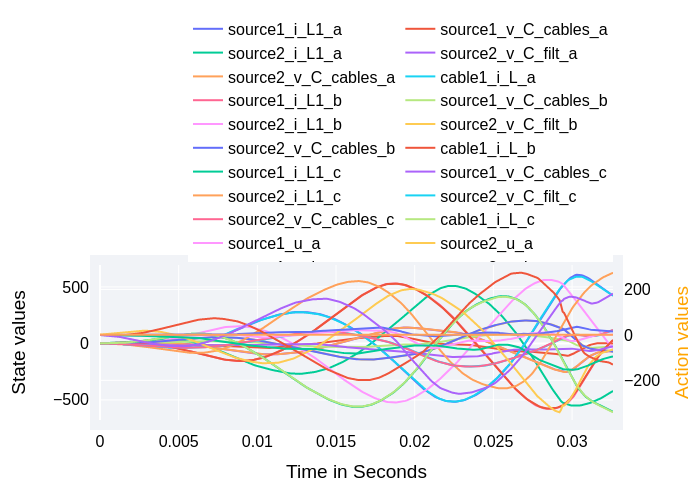

In [9]:
hook = DataHook(collect_state_ids = env.state_ids,
                collect_action_ids = env.action_ids)

hook = Simulate(controllers, env, hook=hook)


RenderHookResults(hook = hook,
                    states_to_plot  = env.state_ids,
                    actions_to_plot = env.action_ids,
                    plot_reward=true)

We can track the training metrics on wandb website in realtime. Here we provide the plots of the actor and critic loss during training for illustration purposes:
<!-- put images side by side-->
<!-- ![Wandb metrics](figures/TD3_actor_loss.svg) -->
<img src="figures/TD3_actor_loss.svg"
        style="width:700px;"/>
<img src="figures/TD3_critic_loss.svg"
        style="width:700px;"/>
<!-- ![Wandb metrics](figures/TD3_critic_loss.svg) -->